from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


### import

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import warnings
import os

In [ ]:
warnings.filterwarnings('ignore', category=UserWarning, module='keras')

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Importing libraries
from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, Conv1D, MaxPooling1D, Flatten
from keras.layers import Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint

### Load Data

In [ ]:
# Data directory
DATADIR = '/content/drive/MyDrive/Colab Notebooks/UCI HAR Dataset'

# Activity labels
ACTIVITIES = {
    1: 'WALKING',
    2: 'WALKING_UPSTAIRS',
    3: 'WALKING_DOWNSTAIRS',
    4: 'SITTING',
    5: 'STANDING',
    6: 'LAYING'
}

In [ ]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [ ]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'{DATADIR}/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).to_numpy()
        )

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [ ]:
def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'{DATADIR}/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).to_numpy(), y.values


In [ ]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test, y_train_raw, y_test_raw
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_train_raw = load_y('train')
    y_test, y_test_raw = load_y('test')

    return X_train, X_test, y_train, y_test, y_train_raw, y_test_raw

In [ ]:
# Enhanced CSV data processing for external data
def process_csv_data(file_path, train_mean=None, train_std=None):
    """
    Process external CSV data for inference
    Returns normalized data in the correct shape for the model
    """
    # Load CSV data with actual columns
    df = pd.read_csv(file_path)

    # Check for required columns
    required_columns = ['gFx', 'gFy', 'gFz', 'wx', 'wy', 'wz', 'ax', 'ay', 'az']
    missing_columns = [col for col in required_columns if col not in df.columns]

    if missing_columns:
        raise ValueError(f"Missing required columns: {missing_columns}")

    # Map CSV columns to required features
    raw_data = np.hstack([
        df[['gFx', 'gFy', 'gFz']].values,  # Body acceleration
        df[['wx', 'wy', 'wz']].values,     # Gyroscope
        df[['ax', 'ay', 'az']].values      # Total acceleration
    ])

    # Normalize if mean and std are provided
    if train_mean is not None and train_std is not None:
        raw_data = (raw_data - train_mean) / train_std

    # Create windows of 128 timesteps
    windows = []
    for i in range(0, len(raw_data) - 127, 32):  # Stride of 32 for less overlap
        window = raw_data[i:i+128]
        if len(window) == 128:  # Ensure complete window
            windows.append(window)

    if not windows:
        raise ValueError("Not enough data to create windows")

    return np.array(windows)

In [ ]:
# Post-processing for predictions
def post_process_predictions(predictions, threshold=0.5, smoothing_window=5):
    """
    Apply post-processing to raw predictions:
    1. Threshold probabilities
    2. Apply smoothing to reduce noise
    3. Return predicted class indices and labels
    """
    # Get predicted class indices
    pred_indices = np.argmax(predictions, axis=1)

    # Apply smoothing with a sliding window
    if len(pred_indices) >= smoothing_window:
        smoothed_indices = np.zeros_like(pred_indices)
        for i in range(len(pred_indices)):
            start = max(0, i - smoothing_window // 2)
            end = min(len(pred_indices), i + smoothing_window // 2 + 1)
            window = pred_indices[start:end]
            # Most common class in window
            values, counts = np.unique(window, return_counts=True)
            smoothed_indices[i] = values[np.argmax(counts)]
        pred_indices = smoothed_indices

    # Map indices to activity labels (add 1 because activities are 1-indexed)
    pred_labels = [ACTIVITIES[idx + 1] for idx in pred_indices]

    return pred_indices, pred_labels

In [ ]:
# Configure session settings
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [ ]:
# Start a session
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)

# Initializing parameters
epochs = 50
batch_size = 16
n_hidden = 32

In [ ]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [ ]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test, Y_train_raw, Y_test_raw = load_data()

<ipython-input-7-2fc0c20de1db>:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(filename, delim_whitespace=True, header=None)
<ipython-input-7-2fc0c20de1db>:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(filename, delim_whitespace=True, header=None)
<ipython-input-7-2fc0c20de1db>:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(filename, delim_whitespace=True, header=None)
<ipython-input-7-2fc0c20de1db>:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(filename, delim_whitespace=True, header=None)
<ipython-input-7-2fc0c20de1d

In [ ]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)
print(f"Timesteps: {timesteps}")
print(f"Input dimensions: {input_dim}")
print(f"Number of training samples: {len(X_train)}")
print(f"Shape of training data: {X_train.shape}")

Timesteps: 128
Input dimensions: 9
Number of training samples: 7352
Shape of training data: (7352, 128, 9)


In [ ]:
# Calculate and store normalization parameters for external data processing
train_mean = np.mean(X_train.reshape(-1, input_dim), axis=0)
train_std = np.std(X_train.reshape(-1, input_dim), axis=0)
np.save('train_normalization_params.npy', {'mean': train_mean, 'std': train_std})


## Defining LSTM Network model:

In [ ]:
"""## Defining LSTM Network model:"""

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_lstm_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [ ]:
# Initiliazing the sequential model
model1 = Sequential()
# Configuring the parameters with Bidirectional LSTM
model1.add(Bidirectional(LSTM(n_hidden), input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model1.add(Dropout(0.5))
# Adding a dense output layer with softmax activation (changed from sigmoid)
model1.add(Dense(n_classes, activation='softmax'))
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 64)                  │          10,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,142 (43.52 KB)

 Trainable params: 11,142 (43.52 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compiling the model
model1.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


In [ ]:
# Training the model with early stopping and checkpoints
lstm_history = model1.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.4760 - loss: 1.2478
Epoch 1: val_accuracy improved from -inf to 0.69053, saving model to best_lstm_model.h5


460/460 ━━━━━━━━━━━━━━━━━━━━ 37s 73ms/step - accuracy: 0.4763 - loss: 1.2472 - val_accuracy: 0.6905 - val_loss: 0.7874
Epoch 2/50
459/460 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7372 - loss: 0.6548
Epoch 2: val_accuracy improved from 0.69053 to 0.76145, saving model to best_lstm_model.h5


460/460 ━━━━━━━━━━━━━━━━━━━━ 37s 63ms/step - accuracy: 0.7373 - loss: 0.6545 - val_accuracy: 0.7615 - val_loss: 0.6678
Epoch 3/50
459/460 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8553 - loss: 0.4295
Epoch 3: val_accuracy improved from 0.76145 to 0.83848, saving model to best_lstm_model.h5


460/460 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.8554 - loss: 0.4293 - val_accuracy: 0.8385 - val_loss: 0.4828
Epoch 4/50
459/460 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8888 - loss: 0.3162
Epoch 4: val_accuracy improved from 0.83848 to 0.86155, saving model to best_lstm_model.h5


460/460 ━━━━━━━━━━━━━━━━━━━━ 32s 69ms/step - accuracy: 0.8888 - loss: 0.3162 - val_accuracy: 0.8616 - val_loss: 0.4544
Epoch 5/50
459/460 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9110 - loss: 0.2668
Epoch 5: val_accuracy improved from 0.86155 to 0.87852, saving model to best_lstm_model.h5


460/460 ━━━━━━━━━━━━━━━━━━━━ 39s 65ms/step - accuracy: 0.9111 - loss: 0.2668 - val_accuracy: 0.8785 - val_loss: 0.3585
Epoch 6/50
459/460 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9190 - loss: 0.2186
Epoch 6: val_accuracy improved from 0.87852 to 0.88802, saving model to best_lstm_model.h5


460/460 ━━━━━━━━━━━━━━━━━━━━ 43s 70ms/step - accuracy: 0.9191 - loss: 0.2186 - val_accuracy: 0.8880 - val_loss: 0.3012
Epoch 7/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9267 - loss: 0.2024
Epoch 7: val_accuracy improved from 0.88802 to 0.89617, saving model to best_lstm_model.h5


460/460 ━━━━━━━━━━━━━━━━━━━━ 29s 63ms/step - accuracy: 0.9267 - loss: 0.2023 - val_accuracy: 0.8962 - val_loss: 0.3089
Epoch 8/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9346 - loss: 0.1826
Epoch 8: val_accuracy did not improve from 0.89617
460/460 ━━━━━━━━━━━━━━━━━━━━ 43s 68ms/step - accuracy: 0.9346 - loss: 0.1825 - val_accuracy: 0.8924 - val_loss: 0.3144
Epoch 9/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9355 - loss: 0.1674
Epoch 9: val_accuracy improved from 0.89617 to 0.91653, saving model to best_lstm_model.h5


460/460 ━━━━━━━━━━━━━━━━━━━━ 39s 63ms/step - accuracy: 0.9355 - loss: 0.1674 - val_accuracy: 0.9165 - val_loss: 0.2386
Epoch 10/50
459/460 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9356 - loss: 0.1694
Epoch 10: val_accuracy did not improve from 0.91653
460/460 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.9356 - loss: 0.1694 - val_accuracy: 0.9019 - val_loss: 0.3262
Epoch 11/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9395 - loss: 0.1550
Epoch 11: val_accuracy did not improve from 0.91653
460/460 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.9395 - loss: 0.1550 - val_accuracy: 0.9019 - val_loss: 0.2715
Epoch 12/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9397 - loss: 0.1629
Epoch 12: val_accuracy did not improve from 0.91653
460/460 ━━━━━━━━━━━━━━━━━━━━ 43s 68ms/step - accuracy: 0.9397 - loss: 0.1629 - val_accuracy: 0.8914 - val_loss: 0.3603
Epoch 13/50
459/460 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9442 - loss: 0.1565
Epoch 13: val_ac

In [ ]:
# Testing
score = model1.evaluate(X_test, Y_test)
print("Accuracy: ", score[1])
print("Loss: ", score[0])

93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8889 - loss: 0.3046
Accuracy:  0.9165253043174744
Loss:  0.23862195014953613


In [ ]:
# Generate predictions for confusion matrix
y_pred = model1.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(Y_test, axis=1)

93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step


In [ ]:
# Display confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true_classes, y_pred_classes))

# Display classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes,
                          target_names=[ACTIVITIES[i+1] for i in range(n_classes)]))


Confusion Matrix:
[[468   6  22   0   0   0]
 [  6 443  21   1   0   0]
 [  2   1 417   0   0   0]
 [  0   2   0 368 121   0]
 [  5   1   0  57 469   0]
 [  0   1   0   0   0 536]]
Classification Report:
                    precision    recall  f1-score   support

           WALKING       0.97      0.94      0.96       496
  WALKING_UPSTAIRS       0.98      0.94      0.96       471
WALKING_DOWNSTAIRS       0.91      0.99      0.95       420
           SITTING       0.86      0.75      0.80       491
          STANDING       0.79      0.88      0.84       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.92      2947
         macro avg       0.92      0.92      0.92      2947
      weighted avg       0.92      0.92      0.92      2947



## Defining CNN-LSTM Network model:

In [ ]:
"""## Defining CNN-LSTM Network model:"""

# Reshape data for CNN-LSTM model
n_steps, n_length = 4, 32
X_train_cnn = X_train.reshape((X_train.shape[0], n_steps, n_length, input_dim))
X_test_cnn = X_test.reshape((X_test.shape[0], n_steps, n_length, input_dim))

print(f"Reshaped data for CNN-LSTM: {X_train_cnn.shape}")

Reshaped data for CNN-LSTM: (7352, 4, 32, 9)


In [ ]:
# Define model
# CNN layers for feature extraction on input data combined with LSTMs to support sequence prediction
model2 = Sequential()
# CNN layers
model2.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,input_dim)))
model2.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model2.add(TimeDistributed(Dropout(0.5)))
model2.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model2.add(TimeDistributed(Flatten()))
# Bidirectional LSTM layer
model2.add(Bidirectional(LSTM(n_hidden)))
model2.add(Dropout(0.5))
model2.add(Dense(n_hidden, activation='relu'))
model2.add(Dense(n_classes, activation='softmax'))  # Changed to softmax
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, None, 30, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, None, 28, 64)        │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, None, 28, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, None, 14, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, None, 896)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │         237,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 254,246 (993.15 KB)

 Trainable params: 254,246 (993.15 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Define additional callbacks for CNN-LSTM
cnn_lstm_checkpoint = ModelCheckpoint(
    'best_cnn_lstm_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [ ]:

# Training the model
cnn_lstm_history = model2.fit(X_train_cnn,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test_cnn, Y_test),
          epochs=epochs,
          callbacks=[early_stopping, cnn_lstm_checkpoint])


Epoch 1/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6709 - loss: 0.7906
Epoch 1: val_accuracy improved from -inf to 0.85477, saving model to best_cnn_lstm_model.h5


460/460 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.6712 - loss: 0.7900 - val_accuracy: 0.8548 - val_loss: 0.4178
Epoch 2/50
459/460 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9160 - loss: 0.2141
Epoch 2: val_accuracy improved from 0.85477 to 0.86427, saving model to best_cnn_lstm_model.h5


460/460 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.9161 - loss: 0.2140 - val_accuracy: 0.8643 - val_loss: 0.3851
Epoch 3/50
459/460 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9402 - loss: 0.1374
Epoch 3: val_accuracy improved from 0.86427 to 0.88599, saving model to best_cnn_lstm_model.h5


460/460 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.9402 - loss: 0.1373 - val_accuracy: 0.8860 - val_loss: 0.3673
Epoch 4/50
459/460 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9447 - loss: 0.1262
Epoch 4: val_accuracy improved from 0.88599 to 0.89175, saving model to best_cnn_lstm_model.h5


460/460 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.9447 - loss: 0.1262 - val_accuracy: 0.8918 - val_loss: 0.3557
Epoch 5/50
458/460 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9508 - loss: 0.1114
Epoch 5: val_accuracy did not improve from 0.89175
460/460 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.9508 - loss: 0.1114 - val_accuracy: 0.8911 - val_loss: 0.4034
Epoch 6/50
458/460 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9533 - loss: 0.1079
Epoch 6: val_accuracy improved from 0.89175 to 0.90974, saving model to best_cnn_lstm_model.h5


460/460 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.9533 - loss: 0.1079 - val_accuracy: 0.9097 - val_loss: 0.3244
Epoch 7/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9526 - loss: 0.1007
Epoch 7: val_accuracy did not improve from 0.90974
460/460 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.9526 - loss: 0.1007 - val_accuracy: 0.8962 - val_loss: 0.3771
Epoch 8/50
458/460 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9577 - loss: 0.0908
Epoch 8: val_accuracy did not improve from 0.90974
460/460 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.9578 - loss: 0.0908 - val_accuracy: 0.9067 - val_loss: 0.3941
Epoch 9/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9525 - loss: 0.1030
Epoch 9: val_accuracy improved from 0.90974 to 0.91008, saving model to best_cnn_lstm_model.h5


460/460 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.9525 - loss: 0.1030 - val_accuracy: 0.9101 - val_loss: 0.4244
Epoch 10/50
458/460 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9590 - loss: 0.0926
Epoch 10: val_accuracy did not improve from 0.91008
460/460 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.9590 - loss: 0.0926 - val_accuracy: 0.9033 - val_loss: 0.4713
Epoch 11/50
458/460 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9597 - loss: 0.0907
Epoch 11: val_accuracy did not improve from 0.91008
460/460 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.9597 - loss: 0.0907 - val_accuracy: 0.9077 - val_loss: 0.4286
Epoch 12/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9644 - loss: 0.0789
Epoch 12: val_accuracy did not improve from 0.91008
460/460 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.9643 - loss: 0.0789 - val_accuracy: 0.9009 - val_loss: 0.4259
Epoch 13/50
458/460 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9643 - loss: 0.0779
Epoch 13: val_ac

In [ ]:
# Testing
score = model2.evaluate(X_test_cnn, Y_test)
print("Accuracy: ", score[1])
print("Loss: ", score[0])

# Generate predictions for confusion matrix
y_pred = model2.predict(X_test_cnn)
y_pred_classes = np.argmax(y_pred, axis=1)

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8626 - loss: 0.3725
Accuracy:  0.9097387194633484
Loss:  0.3243808448314667
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


In [ ]:
# Display confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true_classes, y_pred_classes))

# Display classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes,
                          target_names=[ACTIVITIES[i+1] for i in range(n_classes)]))


Confusion Matrix:
[[467   4  25   0   0   0]
 [  1 449  21   0   0   0]
 [  4   3 413   0   0   0]
 [  0   3   0 428  55   5]
 [  0   0   0 120 412   0]
 [  0  25   0   0   0 512]]
Classification Report:
                    precision    recall  f1-score   support

           WALKING       0.99      0.94      0.96       496
  WALKING_UPSTAIRS       0.93      0.95      0.94       471
WALKING_DOWNSTAIRS       0.90      0.98      0.94       420
           SITTING       0.78      0.87      0.82       491
          STANDING       0.88      0.77      0.82       532
            LAYING       0.99      0.95      0.97       537

          accuracy                           0.91      2947
         macro avg       0.91      0.91      0.91      2947
      weighted avg       0.91      0.91      0.91      2947



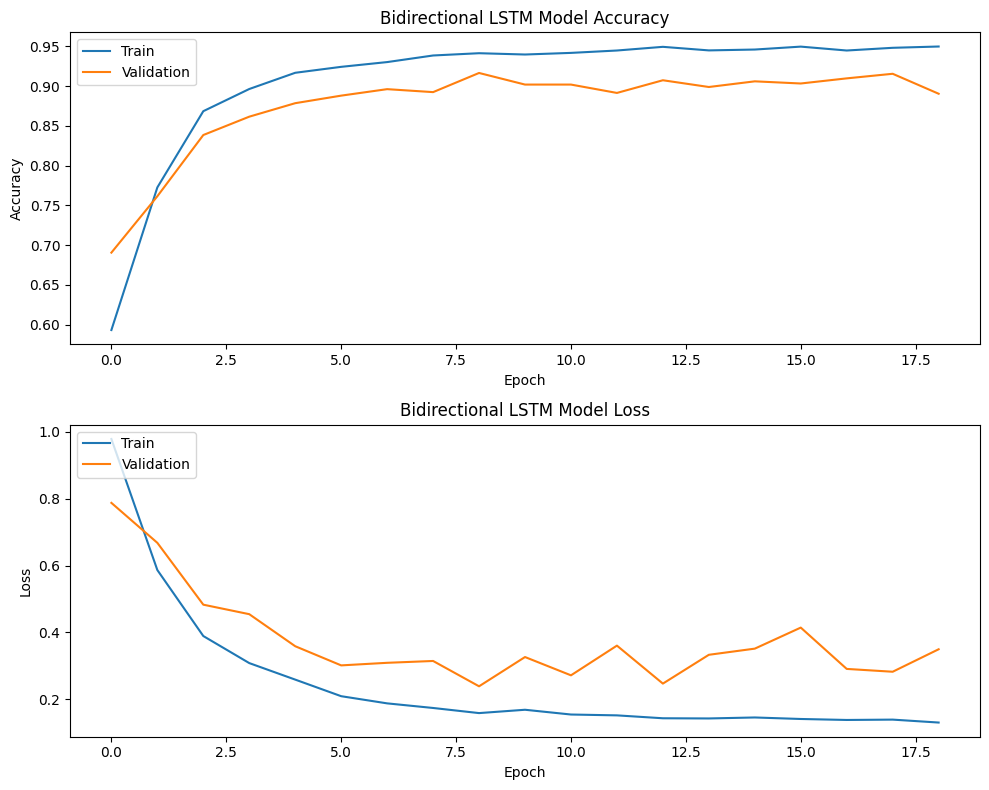

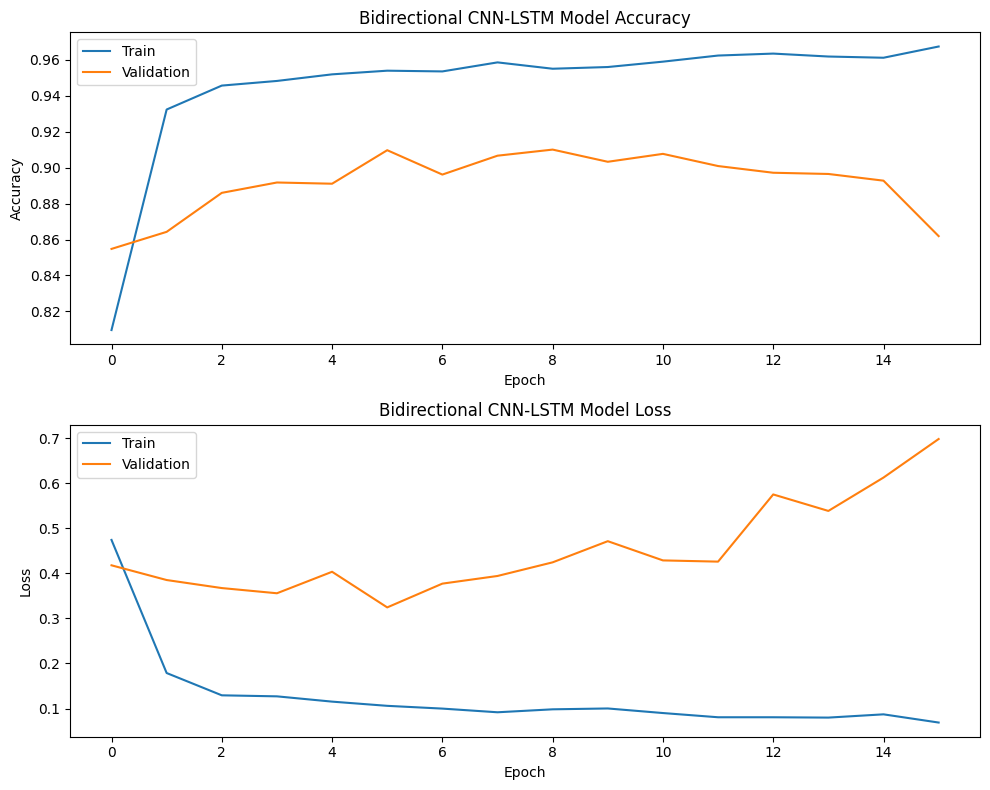

In [ ]:
import matplotlib.pyplot as plt

def plot_model_history(history, model_name):
    """
    Plots the training and validation accuracy and loss curves for a given model.

    Args:
        history: The training history object returned by model.fit.
        model_name: The name of the model (e.g., "LSTM", "CNN-LSTM").
    """

    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    # Plot training & validation accuracy values
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title(f'{model_name} Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title(f'{model_name} Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot the graphs
plot_model_history(lstm_history, "Bidirectional LSTM")
plot_model_history(cnn_lstm_history, "Bidirectional CNN-LSTM")



In [ ]:
# Save models in multiple formats
model1.save('har_lstm_model.h5')
model1.save('har_lstm.keras')

model2.save('har_cnn_lstm_model.h5')
model2.save('har_cnn_lstm.keras')

<ipython-input-3-37050f66274c>:56: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(filename, delim_whitespace=True, header=None)
<ipython-input-3-37050f66274c>:56: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(filename, delim_whitespace=True, header=None)
<ipython-input-3-37050f66274c>:56: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(filename, delim_whitespace=True, header=None)
<ipython-input-3-37050f66274c>:56: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(filename, delim_whitespace=True, header=None)
<ipython-input-3-37050f6

Timesteps: 128
Input dimensions: 9
Number of training samples: 7352
Shape of training data: (7352, 128, 9)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 128, 128)            │          37,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 82,278 (321.40 KB)

 Trainable params: 81,830 (319.65 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.4429 - loss: 2.0338
Epoch 1: val_accuracy improved from -inf to 0.75704, saving model to best_lstm_model.keras
460/460 ━━━━━━━━━━━━━━━━━━━━ 108s 213ms/step - accuracy: 0.4431 - loss: 2.0329 - val_accuracy: 0.7570 - val_loss: 0.9813 - learning_rate: 0.0010
Epoch 2/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.6671 - loss: 1.1205
Epoch 2: val_accuracy improved from 0.75704 to 0.86291, saving model to best_lstm_model.keras
460/460 ━━━━━━━━━━━━━━━━━━━━ 147s 225ms/step - accuracy: 0.6672 - loss: 1.1202 - val_accuracy: 0.8629 - val_loss: 0.6235 - learning_rate: 0.0010
Epoch 3/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.7916 - loss: 0.7497
Epoch 3: val_accuracy improved from 0.86291 to 0.87648, saving model to best_lstm_model.keras
460/460 ━━━━━━━━━━━━━━━━━━━━ 137s 213ms/step - accuracy: 0.7917 - loss: 0.7495 - val_accuracy: 0.8765 - val_loss: 0.4735 - learning_rate: 0.0010
Epoch 4/50
460/460 ━━━

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, None, 28, 128)       │           5,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, None, 28, 128)       │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, None, 28, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, None, 26, 64)        │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, None, 26, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, None, 26, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, None, 13, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, None, 13, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, None, 832)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, None, 832)           │           3,328 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, None, 128)           │         459,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, None, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 538,278 (2.05 MB)

 Trainable params: 535,782 (2.04 MB)

 Non-trainable params: 2,496 (9.75 KB)

Epoch 1/50
459/460 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.4709 - loss: 1.9209
Epoch 1: val_accuracy improved from -inf to 0.48252, saving model to best_cnn_lstm_model.keras
460/460 ━━━━━━━━━━━━━━━━━━━━ 55s 84ms/step - accuracy: 0.4712 - loss: 1.9193 - val_accuracy: 0.4825 - val_loss: 2.5277 - learning_rate: 0.0010
Epoch 2/50
459/460 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6362 - loss: 1.1382
Epoch 2: val_accuracy improved from 0.48252 to 0.50153, saving model to best_cnn_lstm_model.keras
460/460 ━━━━━━━━━━━━━━━━━━━━ 38s 79ms/step - accuracy: 0.6363 - loss: 1.1377 - val_accuracy: 0.5015 - val_loss: 2.0965 - learning_rate: 0.0010
Epoch 3/50
459/460 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7094 - loss: 0.8697
Epoch 3: val_accuracy improved from 0.50153 to 0.55548, saving model to best_cnn_lstm_model.keras
460/460 ━━━━━━━━━━━━━━━━━━━━ 40s 78ms/step - accuracy: 0.7095 - loss: 0.8694 - val_accuracy: 0.5555 - val_loss: 1.7616 - learning_rate: 0.0010
Epoch 4/50
459/460 

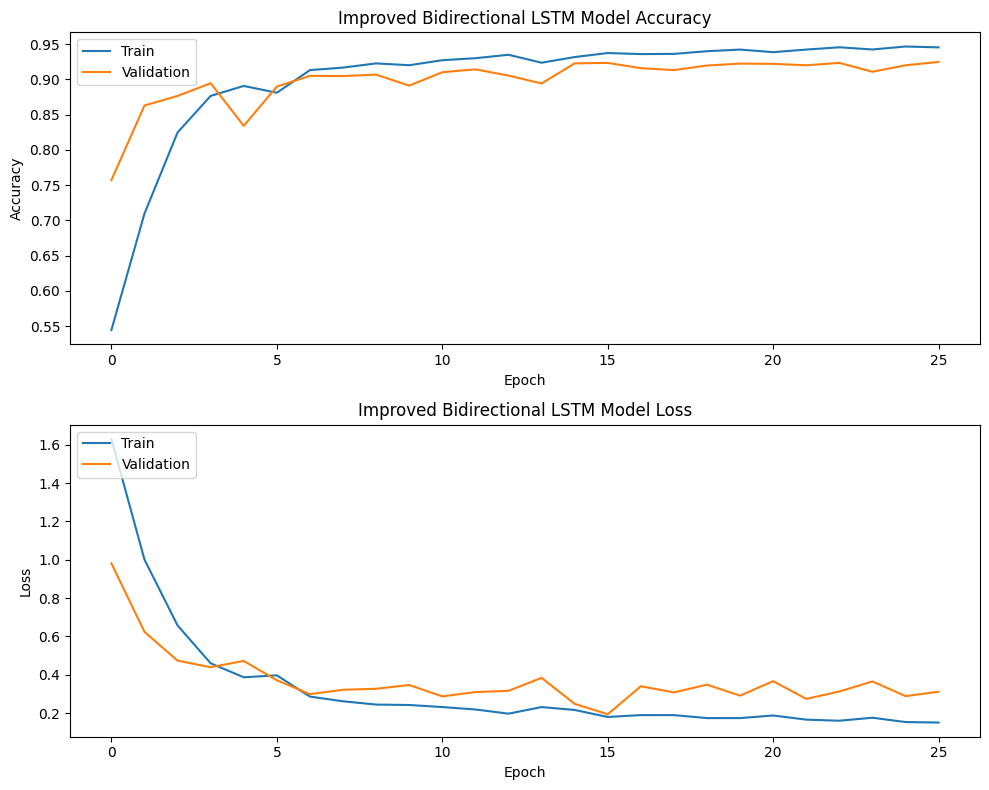

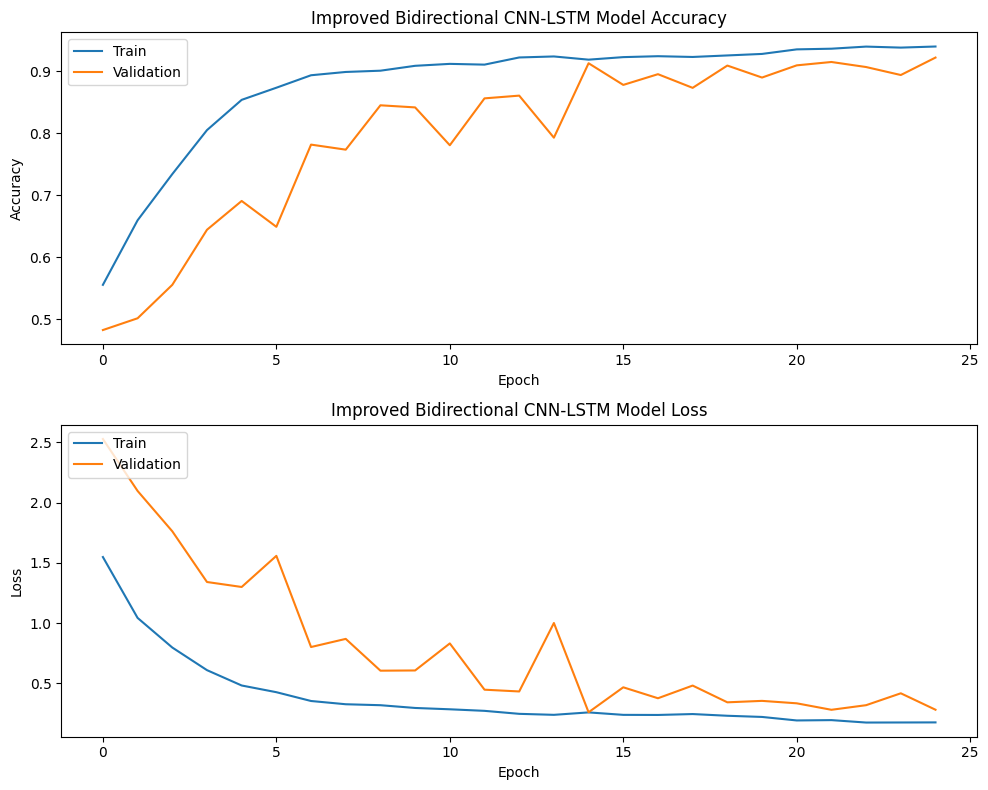

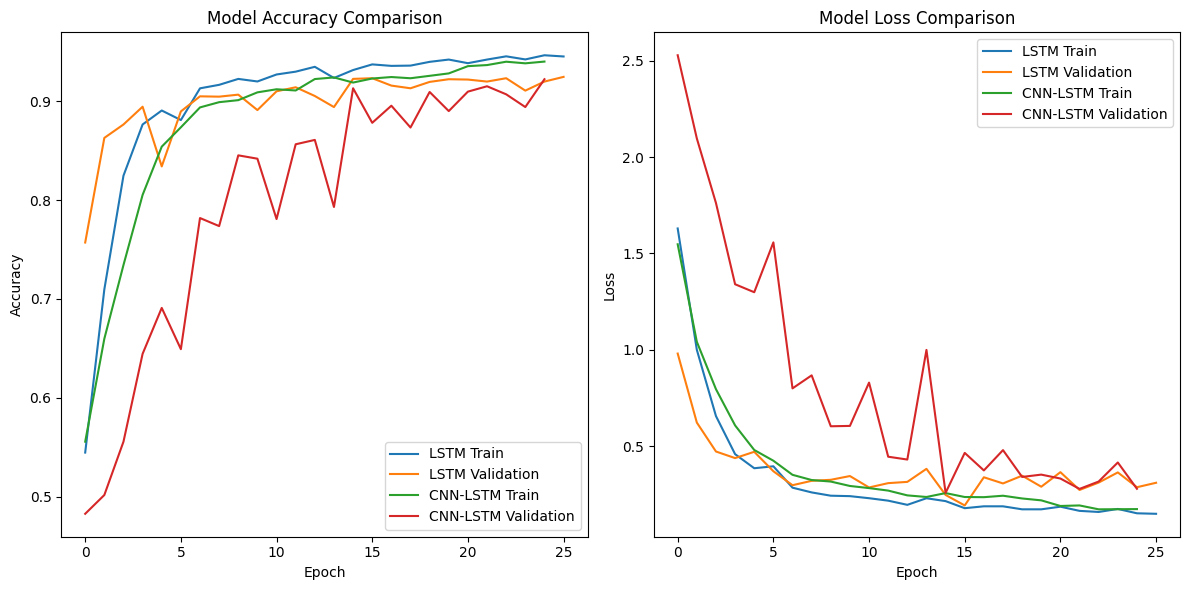

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import warnings
import os

warnings.filterwarnings('ignore', category=UserWarning, module='keras')

np.random.seed(42)
tf.random.set_seed(42)

# Importing libraries
from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from keras.layers import Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2

"""### Load Data"""

# Data directory
DATADIR = '/content/drive/MyDrive/Colab Notebooks/UCI HAR Dataset'

# Activity labels
ACTIVITIES = {
    1: 'WALKING',
    2: 'WALKING_UPSTAIRS',
    3: 'WALKING_DOWNSTAIRS',
    4: 'SITTING',
    5: 'STANDING',
    6: 'LAYING'
}

# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'{DATADIR}/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).to_numpy()
        )

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'{DATADIR}/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).to_numpy(), y.values

def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test, y_train_raw, y_test_raw
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_train_raw = load_y('train')
    y_test, y_test_raw = load_y('test')

    return X_train, X_test, y_train, y_test, y_train_raw, y_test_raw

# Enhanced CSV data processing for external data
def process_csv_data(file_path, train_mean=None, train_std=None):
    """
    Process external CSV data for inference
    Returns normalized data in the correct shape for the model
    """
    # Load CSV data with actual columns
    df = pd.read_csv(file_path)

    # Check for required columns
    required_columns = ['gFx', 'gFy', 'gFz', 'wx', 'wy', 'wz', 'ax', 'ay', 'az']
    missing_columns = [col for col in required_columns if col not in df.columns]

    if missing_columns:
        raise ValueError(f"Missing required columns: {missing_columns}")

    # Map CSV columns to required features
    raw_data = np.hstack([
        df[['gFx', 'gFy', 'gFz']].values,  # Body acceleration
        df[['wx', 'wy', 'wz']].values,     # Gyroscope
        df[['ax', 'ay', 'az']].values      # Total acceleration
    ])

    # Normalize if mean and std are provided
    if train_mean is not None and train_std is not None:
        raw_data = (raw_data - train_mean) / train_std

    # Create windows of 128 timesteps
    windows = []
    for i in range(0, len(raw_data) - 127, 32):  # Stride of 32 for less overlap
        window = raw_data[i:i+128]
        if len(window) == 128:  # Ensure complete window
            windows.append(window)

    if not windows:
        raise ValueError("Not enough data to create windows")

    return np.array(windows)

# Post-processing for predictions
def post_process_predictions(predictions, threshold=0.5, smoothing_window=5):
    """
    Apply post-processing to raw predictions:
    1. Threshold probabilities
    2. Apply smoothing to reduce noise
    3. Return predicted class indices and labels
    """
    # Get predicted class indices
    pred_indices = np.argmax(predictions, axis=1)

    # Apply smoothing with a sliding window
    if len(pred_indices) >= smoothing_window:
        smoothed_indices = np.zeros_like(pred_indices)
        for i in range(len(pred_indices)):
            start = max(0, i - smoothing_window // 2)
            end = min(len(pred_indices), i + smoothing_window // 2 + 1)
            window = pred_indices[start:end]
            # Most common class in window
            values, counts = np.unique(window, return_counts=True)
            smoothed_indices[i] = values[np.argmax(counts)]
        pred_indices = smoothed_indices

    # Map indices to activity labels (add 1 because activities are 1-indexed)
    pred_labels = [ACTIVITIES[idx + 1] for idx in pred_indices]

    return pred_indices, pred_labels

# Configure session settings
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

# Start a session
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)

# Initializing parameters
epochs = 50
batch_size = 16
n_hidden = 32

# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

# Loading the train and test data
X_train, X_test, Y_train, Y_test, Y_train_raw, Y_test_raw = load_data()

timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)
print(f"Timesteps: {timesteps}")
print(f"Input dimensions: {input_dim}")
print(f"Number of training samples: {len(X_train)}")
print(f"Shape of training data: {X_train.shape}")

# Calculate and store normalization parameters for external data processing
train_mean = np.mean(X_train.reshape(-1, input_dim), axis=0)
train_std = np.std(X_train.reshape(-1, input_dim), axis=0)
np.save('train_normalization_params.npy', {'mean': train_mean, 'std': train_std})

"""## Defining LSTM Network model:"""

"""## Defining LSTM Network model:"""

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_lstm_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Add ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Initializing the sequential model with improved architecture
model1 = Sequential()

# First LSTM layer with increased units (64) and return_sequences=True
model1.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(timesteps, input_dim)))
model1.add(BatchNormalization())
model1.add(Dropout(0.5))  # Dropout after first LSTM layer

# Second LSTM layer
model1.add(Bidirectional(LSTM(n_hidden)))
model1.add(BatchNormalization())
model1.add(Dropout(0.5))

# Dense layer with ReLU activation and L2 regularization
model1.add(Dense(n_hidden, activation='relu', kernel_regularizer=l2(0.01)))
model1.add(BatchNormalization())
model1.add(Dropout(0.5))

# Output layer with softmax activation
model1.add(Dense(n_classes, activation='softmax'))
model1.summary()

# Compiling the model with Adam optimizer and learning rate of 0.001
model1.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Training the model with early stopping, checkpoints, and reduce LR
lstm_history = model1.fit(
    X_train,
    Y_train,
    batch_size=batch_size,
    validation_data=(X_test, Y_test),
    epochs=epochs,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# Testing
score = model1.evaluate(X_test, Y_test)
print("Accuracy: ", score[1])
print("Loss: ", score[0])

# Generate predictions for confusion matrix
y_pred = model1.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(Y_test, axis=1)

# Display confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true_classes, y_pred_classes))

# Display classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes,
                          target_names=[ACTIVITIES[i+1] for i in range(n_classes)]))

"""## Defining CNN-LSTM Network model:"""

"""## Defining CNN-LSTM Network model:"""

# Reshape data for CNN-LSTM model
n_steps, n_length = 4, 32
X_train_cnn = X_train.reshape((X_train.shape[0], n_steps, n_length, input_dim))
X_test_cnn = X_test.reshape((X_test.shape[0], n_steps, n_length, input_dim))

print(f"Reshaped data for CNN-LSTM: {X_train_cnn.shape}")

# Define model with improved architecture
model2 = Sequential()

# First Conv1D layer with increased filters (128) and larger kernel size (5)
model2.add(TimeDistributed(Conv1D(filters=128, kernel_size=5, activation='relu'),
                         input_shape=(None, n_length, input_dim)))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(Dropout(0.5)))

# Second Conv1D layer with 64 filters
model2.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(Dropout(0.5)))

model2.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model2.add(TimeDistributed(Dropout(0.5)))  # Dropout after MaxPooling

model2.add(TimeDistributed(Flatten()))
model2.add(BatchNormalization())

# First LSTM layer with return_sequences=True
model2.add(Bidirectional(LSTM(64, return_sequences=True)))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))

# Second LSTM layer
model2.add(Bidirectional(LSTM(n_hidden)))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))

# Dense layer with ReLU activation and L2 regularization
model2.add(Dense(n_hidden, activation='relu', kernel_regularizer=l2(0.01)))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))

# Output layer with softmax activation
model2.add(Dense(n_classes, activation='softmax'))
model2.summary()

# Compile model with Adam optimizer and learning rate of 0.001
model2.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Define additional callbacks for CNN-LSTM
cnn_lstm_checkpoint = ModelCheckpoint(
    'best_cnn_lstm_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Training the model with all callbacks
cnn_lstm_history = model2.fit(
    X_train_cnn,
    Y_train,
    batch_size=batch_size,
    validation_data=(X_test_cnn, Y_test),
    epochs=epochs,
    callbacks=[early_stopping, cnn_lstm_checkpoint, reduce_lr]
)

# Testing
score = model2.evaluate(X_test_cnn, Y_test)
print("Accuracy: ", score[1])
print("Loss: ", score[0])

# Generate predictions for confusion matrix
y_pred = model2.predict(X_test_cnn)
y_pred_classes = np.argmax(y_pred, axis=1)

# Display confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true_classes, y_pred_classes))

# Display classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes,
                          target_names=[ACTIVITIES[i+1] for i in range(n_classes)]))

import matplotlib.pyplot as plt

def plot_model_history(history, model_name):
    """
    Plots the training and validation accuracy and loss curves for a given model.

    Args:
        history: The training history object returned by model.fit.
        model_name: The name of the model (e.g., "LSTM", "CNN-LSTM").
    """

    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    # Plot training & validation accuracy values
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title(f'{model_name} Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title(f'{model_name} Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot the graphs
plot_model_history(lstm_history, "Improved Bidirectional LSTM")
plot_model_history(cnn_lstm_history, "Improved Bidirectional CNN-LSTM")

# Save models in multiple formats
model1.save('improved_lstm_model.keras')
model1.save('improved_lstm.keras')

model2.save('improved_cnn_lstm_model.keras')
model2.save('improved_cnn_lstm.keras')

# Save learning curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['accuracy'], label='LSTM Train')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM Validation')
plt.plot(cnn_lstm_history.history['accuracy'], label='CNN-LSTM Train')
plt.plot(cnn_lstm_history.history['val_accuracy'], label='CNN-LSTM Validation')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['loss'], label='LSTM Train')
plt.plot(lstm_history.history['val_loss'], label='LSTM Validation')
plt.plot(cnn_lstm_history.history['loss'], label='CNN-LSTM Train')
plt.plot(cnn_lstm_history.history['val_loss'], label='CNN-LSTM Validation')
plt.title('Model Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()
